<a href="https://colab.research.google.com/github/sanazgit/OpenCV/blob/main/SkinDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📝 Project Overview
This project focuses on **detecting and segmenting human skin regions in color images** using classical computer vision techniques.  
Skin detection is a fundamental task with applications in:
- Face and body tracking,
- Gesture recognition and pose estimation,
- Image editing and beautification,
- Human–computer interaction.


---

## 🎯 Objective
The main objective is to build a **lightweight, real-time capable system** using only OpenCV and traditional image processing.  
Instead of relying on heavy deep learning models, we leverage **color-based rules and morphological processing** to segment skin pixels from the rest of the image.


---

## Load Data

In [ ]:
!unzip '/content/drive/MyDrive/OpenCV/Face_Dataset.zip'

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os, glob
from collections import defaultdict

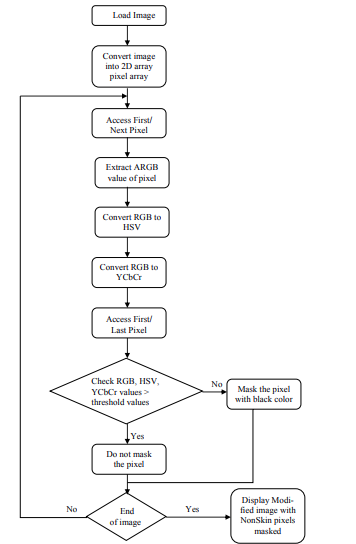

This is Type of image: <class 'numpy.ndarray'>
Shape: (320, 238, 3)


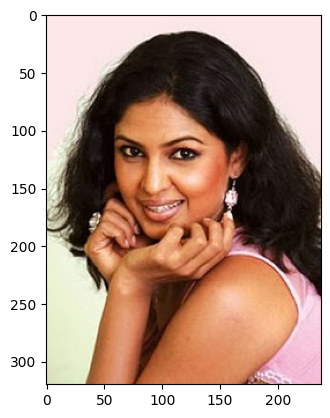

In [42]:
img = cv.imread('/content/Pratheepan_Dataset/FacePhoto/dulani_anuradha7.jpg')
print(f"This is Type of image: {type(img)}\nShape: {img.shape}")
plt.imshow(img[...,::-1]);

## Utils

In [ ]:
def binarize_mask(mask, thresh=128):
    if mask.ndim == 3:
        mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
    _, bw = cv.threshold(mask, thresh, 255, cv.THRESH_BINARY)
    return bw

In [ ]:
def metrics_from_confusion(tp, fp, fn, tn):
    eps = 1e-9
    acc = (tp + tn) / max(tp + fp + fn + tn, 1)
    prec = tp / max(tp + fp, eps)
    rec = tp / max(tp + fn, eps)
    f1 = 2 * prec * rec / max(prec + rec, eps)
    iou = tp / max(tp + fp + fn, eps)
    return acc, prec, rec, f1, iou

## ⚙️ Methodology
### 1. Preprocessing
- Apply a **bilateral filter** to reduce noise while preserving edges.

### 2. Color-Space Based Skin Detection
- Convert the input image into two color spaces:
  - **HSV**: Select a hue and saturation range typically associated with skin tones.
  - **YCrCb**: Use empirically validated thresholds on Cr and Cb channels, which are widely used in skin detection literature.
- Combine both masks to form an initial skin prediction.

### 3. Morphological Refinement
- Apply **opening** to remove small noise.
- Apply **closing** to fill small holes and smooth the mask.

### 4. Post-Processing
- Use **Connected Components** to keep only the largest region (assuming a single person in the image).
- Fill holes (e.g., eyes, mouth) for a cleaner mask closer to ground truth.

In [38]:
def skin_mask_opencv(img_bgr, use_refine=True, grabcut_iter=5):

    img = cv.bilateralFilter(img_bgr, d=7, sigmaColor=75, sigmaSpace=75)

    # HSV
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    H, S, V = cv.split(hsv)
    S_low, S_high = int(0.23*255), int(0.68*255)     # 59–173
    cond_hsv = (H >= 0) & (H <= 25) & (S >= S_low) & (S <= S_high) & (V > 50)

    # YCrCb
    ycc = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv.split(ycc)
    cond_ycc = (Cr >= 135) & (Cr <= 180) & (Cb >= 85) & (Cb <= 135) & (Y > 50)

    mask = (cond_hsv | cond_ycc).astype(np.uint8) * 255

    # Morph
    k5 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, k5, iterations=2)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, k5, iterations=2)

    if not use_refine:
        return mask


    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    v = np.median(gray)
    t1, t2 = int(max(0, 0.66*v)), int(min(255, 1.33*v))
    edges = cv.Canny(gray, t1, t2)
    edges = cv.dilate(edges, cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3)), iterations=1)


    k3 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
    sure_fg = cv.erode(mask, k3, iterations=1)
    outer = cv.dilate(mask, k5, iterations=2)
    sure_bg = cv.bitwise_not(outer)


    unknown = cv.bitwise_not(cv.bitwise_or(sure_fg, sure_bg))

    unknown = cv.bitwise_or(unknown, edges)

    gc_mask = np.full(img.shape[:2], cv.GC_PR_BGD, np.uint8)

    gc_mask[mask == 255] = cv.GC_PR_FGD

    gc_mask[sure_fg == 255] = cv.GC_FGD
    gc_mask[sure_bg == 255] = cv.GC_BGD


    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    cv.grabCut(img, gc_mask, None, bgdModel, fgdModel, grabcut_iter, cv.GC_INIT_WITH_MASK)


    mask_refined = np.where((gc_mask==cv.GC_FGD) | (gc_mask==cv.GC_PR_FGD), 255, 0).astype('uint8')


    mask_refined = cv.morphologyEx(mask_refined, cv.MORPH_CLOSE, k3, iterations=1)

    return mask_refined


In [43]:
def skin_detection(img_dir, gt_dir, out_dir=None,
                    gt_suffix=None, gt_exts=(".png", ".jpg", ".jpeg")):
    os.makedirs(out_dir, exist_ok=True) if out_dir else None

    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.*")))
    exts_ok = (".png",".jpg",".jpeg",".bmp",".tif",".tiff")

    per_image_stats = []
    totals = defaultdict(int)  # tp, fp, fn, tn

    for img_path in img_paths:
        if not img_path.lower().endswith(exts_ok):
            continue

        name = os.path.splitext(os.path.basename(img_path))[0]


        gt_path = None
        if gt_suffix:

            for ext in gt_exts:
                cand = os.path.join(gt_dir, f"{name}{gt_suffix}{ext}")
                if os.path.isfile(cand):
                    gt_path = cand
                    break
        else:

            for ext in gt_exts:
                cand = os.path.join(gt_dir, f"{name}{ext}")
                if os.path.isfile(cand):
                    gt_path = cand
                    break

        if gt_path is None:
            print(f"[warn] GT not found for: {name}")
            continue


        img = cv.imread(img_path, cv.IMREAD_COLOR)
        gt = cv.imread(gt_path, cv.IMREAD_GRAYSCALE)

        if img is None or gt is None:
            print(f"[warn] failed to read: {name}")
            continue


        if (gt.shape[0] != img.shape[0]) or (gt.shape[1] != img.shape[1]):
            gt = cv.resize(gt, (img.shape[1], img.shape[0]), interpolation=cv.INTER_NEAREST)

        #gt_bw = binarize_mask(gt, 128)

        pred = skin_mask_opencv(img)

        gt_bin = (gt > 0)
        pr_bin = (pred > 0)

        tp = int(np.logical_and(pr_bin, gt_bin).sum())
        fp = int(np.logical_and(pr_bin, np.logical_not(gt_bin)).sum())
        fn = int(np.logical_and(np.logical_not(pr_bin), gt_bin).sum())
        tn = int(np.logical_and(np.logical_not(pr_bin), np.logical_not(gt_bin)).sum())

        acc, prec, rec, f1, iou = metrics_from_confusion(tp, fp, fn, tn)
        per_image_stats.append((name, acc, prec, rec, f1, iou))

        totals["tp"] += tp; totals["fp"] += fp
        totals["fn"] += fn; totals["tn"] += tn


        if out_dir:
            cv.imwrite(os.path.join(out_dir, f"{name}_mask.png"), pred)

            vis = cv.bitwise_and(img, img, mask=pred)
            cv.imwrite(os.path.join(out_dir, f"{name}_vis.png"), vis)


    tp, fp, fn, tn = totals["tp"], totals["fp"], totals["fn"], totals["tn"]
    g_acc, g_prec, g_rec, g_f1, g_iou = metrics_from_confusion(tp, fp, fn, tn)

    print("Per-image metrics (ACC / PREC / REC / F1 / IoU):")
    for name, acc, prec, rec, f1, iou in per_image_stats:
        print(f"{name:>20s} | {acc:.4f} {prec:.4f} {rec:.4f} {f1:.4f} {iou:.4f}")

    print("\n=== Global (micro) ===")
    print(f"Accuracy:  {g_acc:.4f}")
    print(f"Precision: {g_prec:.4f}")
    print(f"Recall:    {g_rec:.4f}")
    print(f"F1-score:  {g_f1:.4f}")
    print(f"IoU:       {g_iou:.4f}")

    return (g_acc, g_prec, g_rec, g_f1, g_iou), per_image_stats

In [44]:
img_dir = "/content/Pratheepan_Dataset/FacePhoto"
gt_dir  = "/content/Ground_Truth/GroundT_FacePhoto"
out_dir = "/content/outputs"

gt_suffix = None

global_metrics, per_image = skin_detection(img_dir, gt_dir, out_dir, gt_suffix)

Per-image metrics (ACC / PREC / REC / F1 / IoU):
          0520962400 | 0.4989 0.2412 0.9480 0.3846 0.2381
         06Apr03Face | 0.7290 0.6225 0.9957 0.7661 0.6208
   124511719065943_2 | 0.9224 0.7113 0.9158 0.8007 0.6677
         920480_f520 | 0.7701 0.5305 0.9883 0.6904 0.5272
Aishwarya-Rai_20091229_aatheory | 0.8495 0.6689 0.9978 0.8009 0.6679
    Kishani_-__n_-_5 | 0.9832 0.9146 0.9664 0.9398 0.8864
Matthew_narrowweb__300x381,0 | 0.8538 0.7438 0.9984 0.8525 0.7430
Megan-Fox-Pretty-Face-1-1024x768 | 0.9589 0.8693 0.9691 0.9165 0.8459
Salma-Hayek-face-wi-new-lg | 0.9305 0.8365 0.9977 0.9100 0.8349
Srilankan-Actress-Yamuna-Erandathi-001 | 0.3841 0.3222 0.9919 0.4864 0.3214
Srilankan-Actress-Yamuna-Erandathi-002 | 0.5265 0.2547 0.9677 0.4033 0.2525
  amida-belly-dancer | 0.8344 0.6120 0.9432 0.7424 0.5903
      chenhao0017me9 | 0.9533 0.7659 0.9984 0.8668 0.7649
    dulani_anuradha4 | 0.4579 0.2921 0.6648 0.4059 0.2546
    dulani_anuradha7 | 0.7237 0.5883 0.9488 0.7263 0.5702
evangeli

## 📊 Results
Each test sample shows:
1. The original image,  
2. The predicted skin mask,  
3. The ground-truth mask for comparison.  

This provides a clear visual evaluation of how well the algorithm captures skin regions.

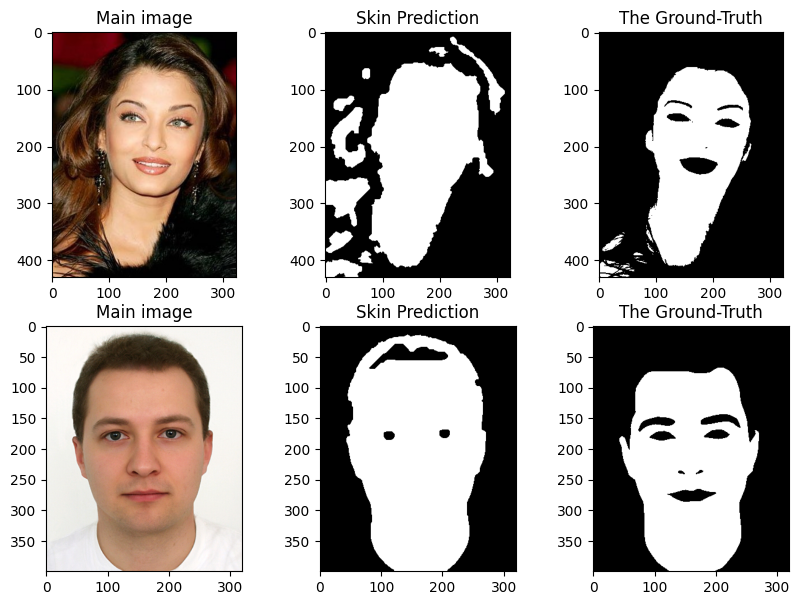

In [41]:
img_1 = cv.imread("/content/Pratheepan_Dataset/FacePhoto/Aishwarya-Rai_20091229_aatheory.jpg")
pred_1 = cv.imread("/content/outputs/Aishwarya-Rai_20091229_aatheory_mask.png", cv.IMREAD_GRAYSCALE)
gt_1  = cv.imread("/content/Ground_Truth/GroundT_FacePhoto/Aishwarya-Rai_20091229_aatheory.png", cv.IMREAD_GRAYSCALE)

img_rgb_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)

img_2 = cv.imread("/content/Pratheepan_Dataset/FacePhoto/m_unsexy_gr.jpg")
pred_2 = cv.imread("/content/outputs/m_unsexy_gr_mask.png", cv.IMREAD_GRAYSCALE)
gt_2 = cv.imread("/content/Ground_Truth/GroundT_FacePhoto/m_unsexy_gr.png", cv.IMREAD_GRAYSCALE)

img_rgb_2 = cv.cvtColor(img_2, cv.COLOR_BGR2RGB)

plt.figure(figsize=[10,7])

plt.subplot(231);plt.imshow(img_rgb_1);plt.title("Main image");
plt.subplot(232);plt.imshow(pred_1, cmap='gray');plt.title("Skin Prediction");
plt.subplot(233);plt.imshow(gt_1,  cmap='gray');plt.title("The Ground-Truth");


plt.subplot(234);plt.imshow(img_rgb_2);plt.title("Main image");
plt.subplot(235);plt.imshow(pred_2 ,  cmap='gray');plt.title("Skin Prediction");
plt.subplot(236);plt.imshow(gt_2 ,  cmap='gray');plt.title("The Ground-Truth");


## 🔮 Future Work
- Integrate with **face/body detectors** to constrain the search area.  
- Explore **lightweight deep learning models** (e.g., U²-Net, BiSeNet) for improved accuracy.  
- Improve robustness to diverse lighting conditions and skin tones using adaptive thresholds.